# EQUIX

In [1]:
import cf_xarray
import dcpy
import eddydiff
import xgcm

import distributed
import hvplot.xarray
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pump
import xarray as xr
from dcpy.oceans import read_osu_microstructure_mat
from IPython.display import Image
from scipy.io import loadmat

import eddydiff as ed

xr.set_options(keep_attrs=True)

plt.rcParams["figure.dpi"] = 140
plt.rcParams["savefig.dpi"] = 200

## Todo


- [x] See if IOP variance terms match chameleon
- [x] is there a consolidated TAO data file
- [x] are they in the PMEL TAO files?
- [ ] use 10 min averages to calculate KT, Jq
- [ ] What is happening with the top few bins
- [x] Take out Chameleon MLD properly not just slice it out
- [x] filter χpod bad estimates using dT/dz - already done
- [x] filter out binned estimates using count

## Data file notes

`indus/chipod/eq08_long/processed/chi_analysis/deglitched/`
1. `allchi_eq08_long.mat` EQUIX EOP APL mooring; renamed to `equix_eop.mat`
2. `mean_chi_*.mat` seem to be IOP files per χpod

EOP units: 204 205 304 312 314 315 328


mean_chi vs summary files

1. summary files: T1, T2, AZ etc.
2. mean_chi files: T1, T2, eps, chi, KT, Jq

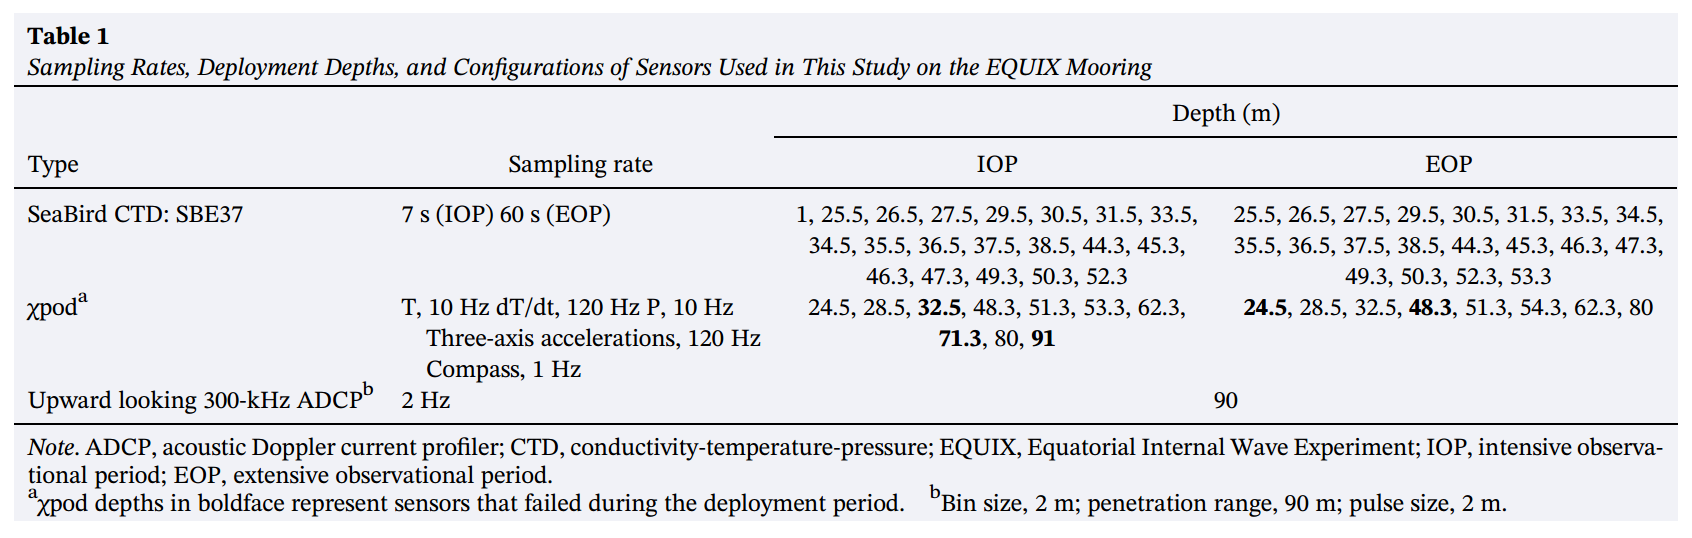

In [2]:
Image("../images/equix-chipods.png")

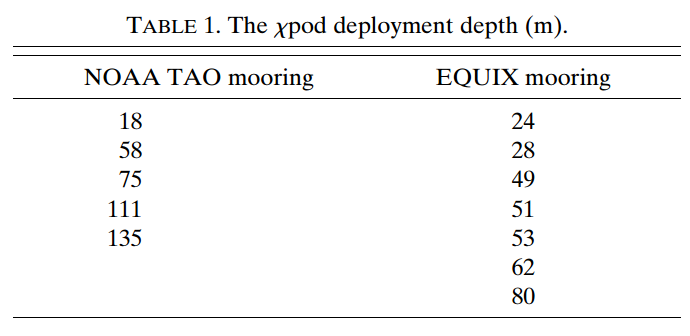

In [3]:
Image("../images/equix-tao-chipods.png")

## Chameleon

In [4]:
chameleon = xr.open_dataset("/home/deepak/datasets/microstructure/osu/equix.nc")
del chameleon["dTdz"]  # not potential temperature?
chameleon = ed.sections.add_ancillary_variables(chameleon)
# take out ML
chameleon = chameleon.where(chameleon.depth > chameleon.mld)
chameleon = chameleon.cf.set_coords(["latitude", "longitude"])
chameleon

<xarray.Dataset>
Dimensions:      (depth: 200, time: 2624, zeuc: 80)
Coordinates:
  * depth        (depth) uint64 1 2 3 4 5 6 7 8 ... 194 195 196 197 198 199 200
    lon          (time) float64 -139.9 -139.9 -139.9 ... -139.9 -139.9 -139.9
    lat          (time) float64 0.06246 0.0622 0.06263 ... 0.06317 0.06341
  * time         (time) datetime64[ns] 2008-10-24T20:36:23 ... 2008-11-08T19:...
  * zeuc         (zeuc) float64 -200.0 -195.0 -190.0 ... 185.0 190.0 195.0
Data variables: (12/46)
    pmax         (time, depth) float64 nan nan 205.9 205.9 ... 203.9 203.9 203.9
    castnumber   (time, depth) float64 nan nan 16.0 ... 2.668e+03 2.668e+03
    AX_TILT      (depth, time) float64 nan nan nan nan ... 0.7031 4.232 1.28
    AY_TILT      (depth, time) float64 nan nan nan nan ... -2.623 -2.121 0.05032
    AZ2          (depth, time) float64 nan nan nan ... 2.612e-06 3.208e-06
    C            (depth, time) float64 nan nan nan nan ... 4.135 4.137 4.164
    ...           ...
    chi_masked   (depth, time) float64 nan nan nan ... 4e-09 2.592e-09 9.245e-09
    Krho         (depth, time) float64 nan nan nan ... 2.642e-05 9.09e-06
    KrhoTz       (depth, time) float64 nan nan nan ... 2.195e-06 4.328e-07
    eps_chi      (depth, time) float64 nan nan nan ... 4.389e-11 5.913e-10
    Kt           (depth, time) float64 nan nan nan ... 1.877e-07 2.039e-06
    KtTz         (depth, time) float64 nan nan nan ... 1.559e-08 9.708e-08
Attributes:
    starttime:  ['Time:20:34:29 298   ' 'Time:20:42:18 298   ' 'Time:20:52:14...
    endtime:    ['Time:20:38:29 298   ' 'Time:20:46:29 298   ' 'Time:20:56:29...
    name:       EQUIX

## Read climatologies

In [150]:
ecco = ed.read_ecco_clim()
ecco

<xarray.Dataset>
Dimensions:      (bounds: 2, lat: 360, lon: 720, pres: 50, time: 12)
Coordinates:
    dayofyear    (time) float64 dask.array<chunksize=(12,), meta=np.ndarray>
  * lat          (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * lon          (lon) float64 20.25 20.75 21.25 21.75 ... 378.8 379.2 379.8
  * pres         (pres) float64 5.0 15.0 25.0 ... 5.039e+03 5.461e+03 5.906e+03
  * time         (time) float64 1.0 2.0 3.0 4.0 5.0 ... 8.0 9.0 10.0 11.0 12.0
    pres_bounds  (bounds, pres) float64 0.0 10.0 20.0 ... 5.672e+03 6.129e+03
Dimensions without coordinates: bounds
Data variables:
    RHOAnoma     (time, pres, lat, lon) float64 dask.array<chunksize=(12, 50, 20, 20), meta=np.ndarray>
    Smean        (time, pres, lat, lon) float64 dask.array<chunksize=(12, 50, 20, 20), meta=np.ndarray>
    Tmean        (time, pres, lat, lon) float64 dask.array<chunksize=(12, 50, 20, 20), meta=np.ndarray>
    dSdia        (time, pres, lat, lon) float64 dask.array<chunksize=(12, 50, 20, 20), meta=np.ndarray>
    dSdz         (time, pres, lat, lon) float64 dask.array<chunksize=(12, 50, 20, 20), meta=np.ndarray>
    dSiso        (time, pres, lat, lon) float64 dask.array<chunksize=(12, 50, 20, 20), meta=np.ndarray>
    dTdia        (time, pres, lat, lon) float64 dask.array<chunksize=(12, 50, 20, 20), meta=np.ndarray>
    dTdz         (time, pres, lat, lon) float64 dask.array<chunksize=(12, 50, 20, 20), meta=np.ndarray>
    dTiso        (time, pres, lat, lon) float64 dask.array<chunksize=(12, 50, 20, 20), meta=np.ndarray>
    pden         (time, pres, lat, lon) float64 dask.array<chunksize=(12, 50, 20, 20), meta=np.ndarray>
    temp         (time, pres, lat, lon) float64 dask.array<chunksize=(12, 50, 20, 20), meta=np.ndarray>
    gamma_n      (time, pres, lat, lon) float64 dask.array<chunksize=(12, 50, 1, 720), meta=np.ndarray>
Attributes:
    dataset:  ecco
    name:     Mean fields and isopycnal, diapycnal gradients from ECCO v4r3

## Read χpod data

In [5]:
iop = xr.load_dataset("/home/deepak/datasets/microstructure/osu/equix/iop.nc")
iop.coords["kind"] = ("depth", ["APL"]*iop.sizes["depth"])
iop

<xarray.Dataset>
Dimensions:       (depth: 7, time: 22560)
Coordinates:
  * time          (time) datetime64[ns] 2008-10-24T07:00:30 ... 2008-11-08T22...
    actual_depth  (depth, time) float64 nan nan nan nan ... 79.48 79.49 79.49
  * depth         (depth) int64 24 28 49 51 53 62 80
    kind          (depth) <U3 'APL' 'APL' 'APL' 'APL' 'APL' 'APL' 'APL'
Data variables:
    chi           (depth, time) float64 nan nan nan ... 4.165e-07 4.835e-07
    theta         (depth, time) float64 nan nan nan nan ... 22.83 22.89 22.94
    dTdz          (depth, time) float64 nan nan nan ... 0.06336 0.03115 0.03851
    eps           (depth, time) float64 nan nan nan ... 1.019e-07 8.438e-08

In [6]:
tao = (
    xr.load_dataset("/home/deepak/datasets/microstructure/osu/equix/tao_may08.nc")
    .reindex(time=iop.time)
    .drop_sel(depth=[39, 84])
)
tao.coords["kind"] = ("depth", ["TAO"]*tao.sizes["depth"])
tao

<xarray.Dataset>
Dimensions:  (depth: 5, time: 22560)
Coordinates:
  * time     (time) datetime64[ns] 2008-10-24T07:00:30 ... 2008-11-08T22:59:29
  * depth    (depth) int64 18 59 69 124 150
    unit     (depth) int64 313 325 319 327 321
    kind     (depth) <U3 'TAO' 'TAO' 'TAO' 'TAO' 'TAO'
Data variables:
    theta    (depth, time) float64 24.49 24.49 24.48 24.49 ... nan nan 16.9 nan
    chi      (depth, time) float64 1.909e-06 1.943e-06 ... 5.374e-10 nan
    eps      (depth, time) float64 9.385e-06 5.47e-06 4.97e-06 ... 4.467e-10 nan
    Kt       (depth, time) float64 0.3299 0.1393 0.1226 ... nan 5.047e-06 nan
    Jq       (depth, time) float64 2.301e+03 1.508e+03 1.3e+03 ... nan 0.151 nan
    dTdz     (depth, time) float64 0.001701 0.00264 0.002587 ... 0.007297 nan

In [7]:
# depths are quite different so simple merge works.
# clusters of 3 χpods are also separated

merged = xr.merge([tao, iop])
merged

<xarray.Dataset>
Dimensions:       (depth: 12, time: 22560)
Coordinates:
  * depth         (depth) int64 18 24 28 49 51 53 59 62 69 80 124 150
  * time          (time) datetime64[ns] 2008-10-24T07:00:30 ... 2008-11-08T22...
    unit          (depth) float64 313.0 nan nan nan ... 319.0 nan 327.0 321.0
    kind          (depth) object 'TAO' 'APL' 'APL' 'APL' ... 'APL' 'TAO' 'TAO'
    actual_depth  (depth, time) float64 nan nan nan nan nan ... nan nan nan nan
Data variables:
    theta         (depth, time) float64 24.49 24.49 24.48 24.49 ... nan 16.9 nan
    chi           (depth, time) float64 1.909e-06 1.943e-06 ... 5.374e-10 nan
    eps           (depth, time) float64 9.385e-06 5.47e-06 ... 4.467e-10 nan
    Kt            (depth, time) float64 0.3299 0.1393 0.1226 ... 5.047e-06 nan
    Jq            (depth, time) float64 2.301e+03 1.508e+03 ... 0.151 nan
    dTdz          (depth, time) float64 0.001701 0.00264 ... 0.007297 nan

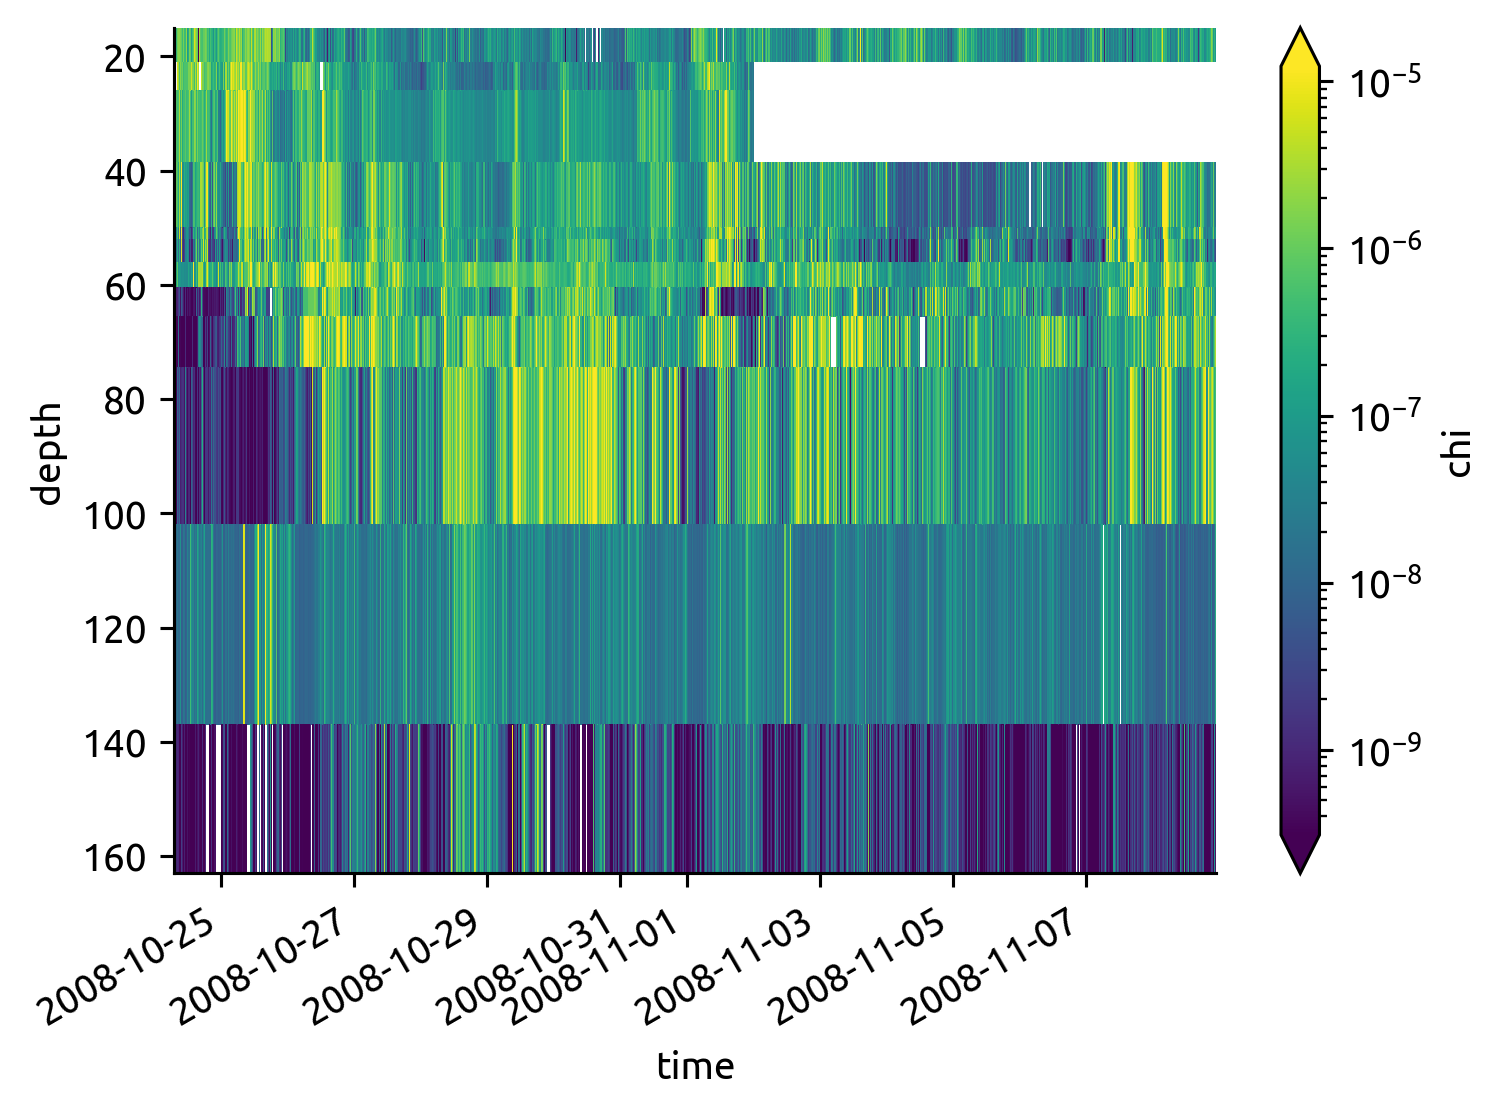

In [8]:
merged.chi.cf.plot(robust=True, norm=mpl.colors.LogNorm())

## Do ancillary variables

In [9]:
resampled = merged[["theta", "chi", "eps", "dTdz"]].coarsen(time=10).mean()
resampled["salt"] = 35 * xr.ones_like(resampled.theta)
resampled["salt"].attrs = {"standard_name": "sea_water_salinity"}
resampled["theta"].attrs = {"standard_name": "sea_water_temperature"}
resampled["pres"] = resampled.depth
resampled["pres"].attrs = {"standard_name": "sea_water_pressure"}
resampled["latitude"] = 0
resampled["longitude"] = -140

In [10]:
resampled = ed.sections.add_ancillary_variables(resampled)

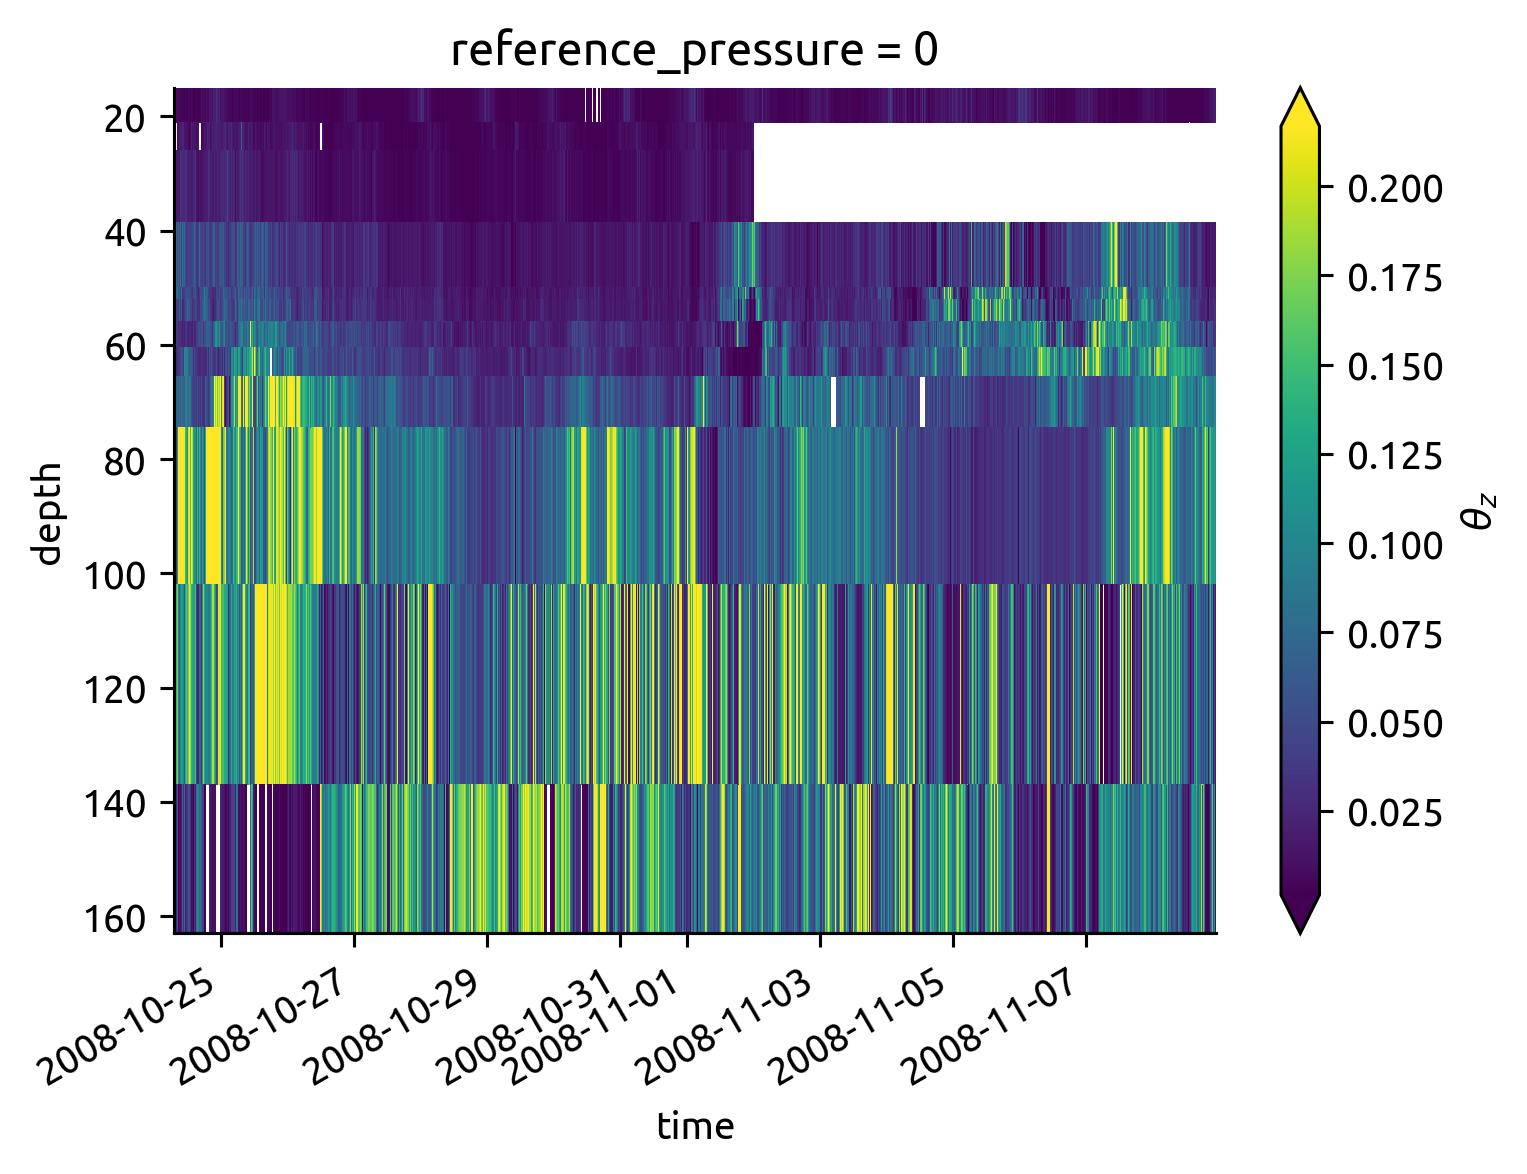

In [11]:
resampled.Tz.cf.plot(robust=True)

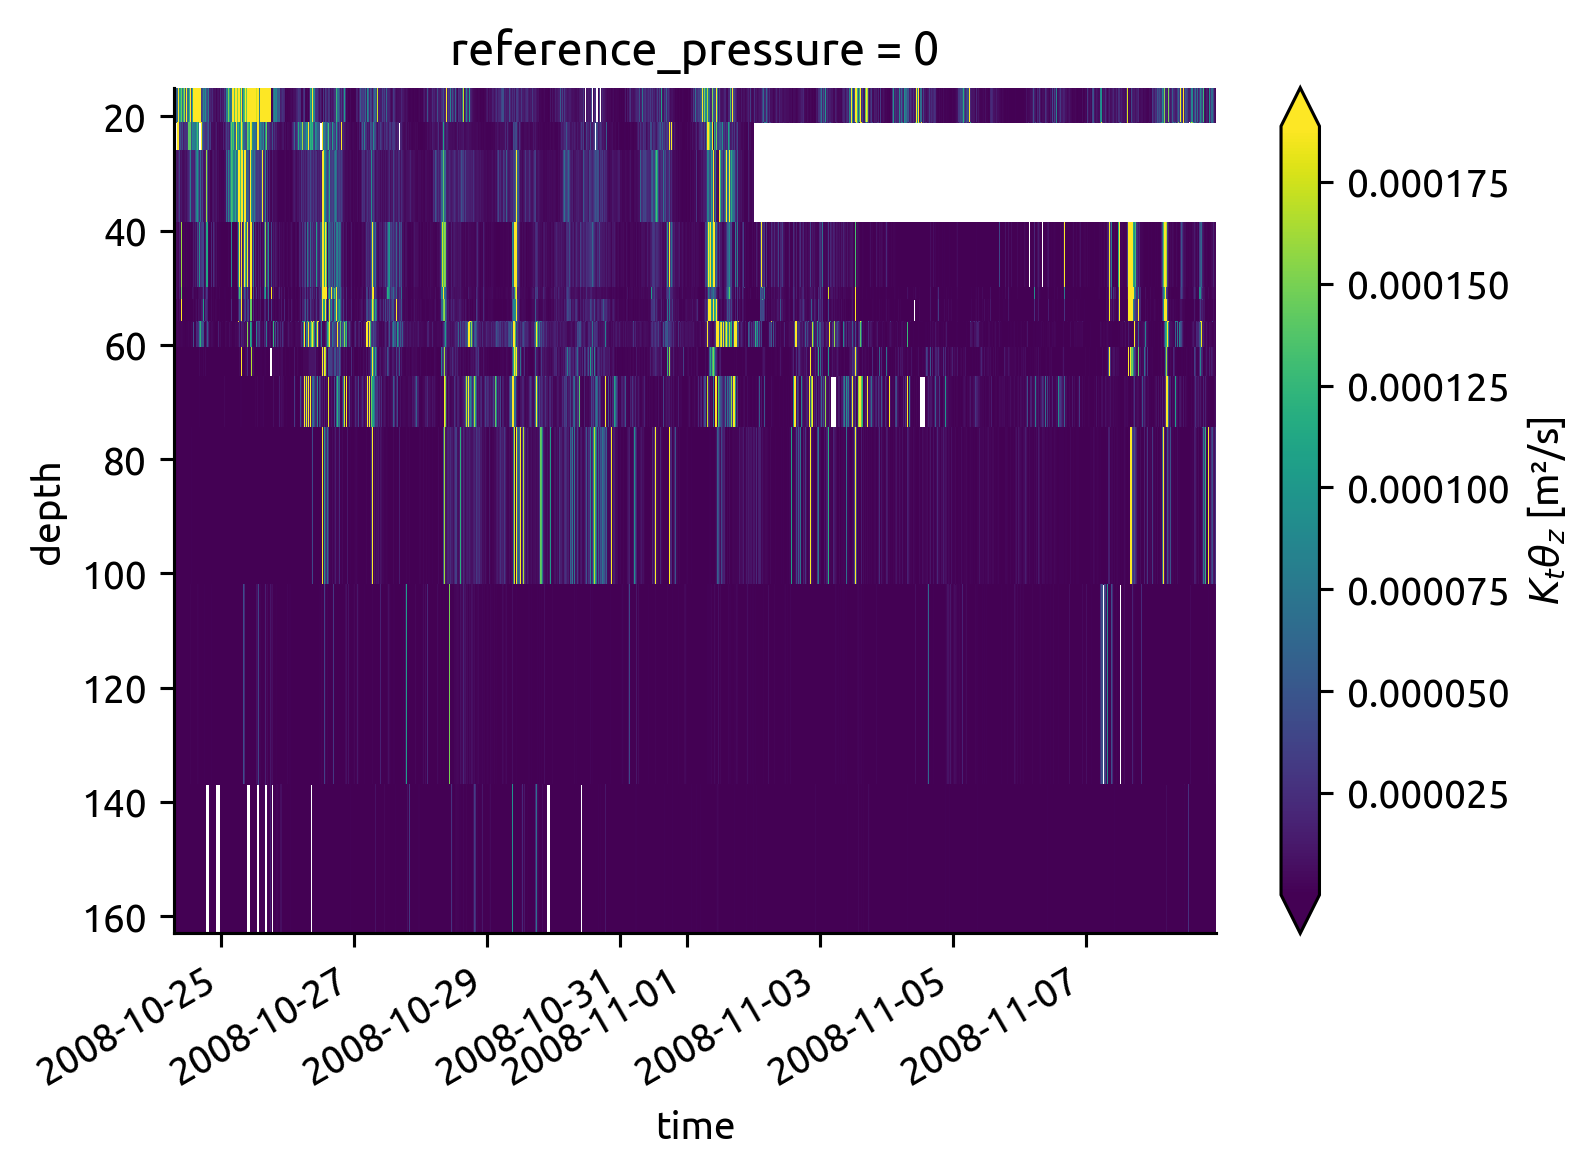

In [12]:
resampled.KtTz.cf.plot(robust=True)

In [13]:
chipod = resampled

## IOP: χpod vs Chameleon

Not sure why this does not totally agree with Perlin & Moum

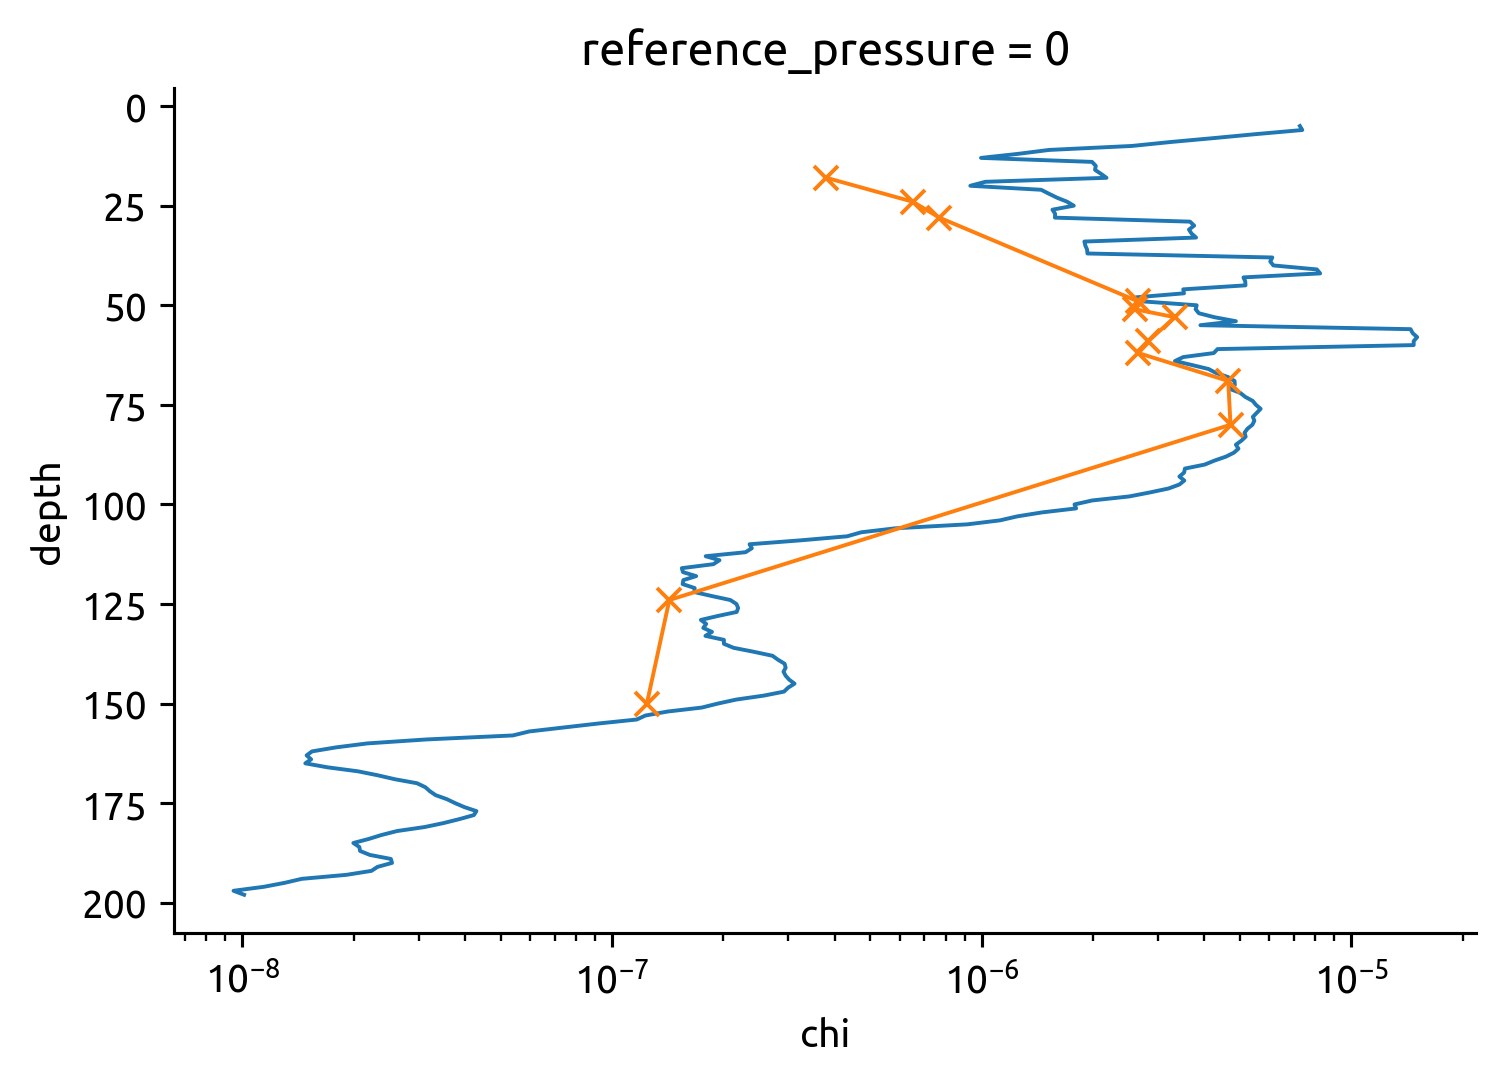

In [14]:
chameleon.chi.mean("time").rolling(depth=5, center=True).mean().cf.plot()
chipod.chi.mean("time").cf.plot(marker="x", xscale="log")

### bin-averaging in density space

In [15]:
bins = ed.sections.choose_bins(
    chameleon.cf["neutral_density"], depth_range=np.arange(25, 200, 10)
)

cham_dens = ed.sections.bin_average_vertical(chameleon, "neutral_density", bins)

merged_dens = ed.sections.bin_average_vertical(
    chipod.where(chipod.Tz > 5e-3), "neutral_density", bins
)
tao_dens = ed.sections.bin_average_vertical(
    chipod.where(chipod.Tz > 5e-3).query(depth="kind == 'TAO'"), "neutral_density", bins
)

apl_dens = ed.sections.bin_average_vertical(
    chipod.where(chipod.Tz > 5e-3).query(depth="kind == 'APL'"), "neutral_density", bins
)

/home/deepak/work/python/xarray/xarray/core/nputils.py:241: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/home/deepak/work/python/xarray/xarray/core/nputils.py:241: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/home/deepak/work/python/xarray/xarray/core/nputils.py:241: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/home/deepak/work/python/xarray/xarray/core/nputils.py:241: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/home/deepak/work/python/xarray/xarray/core/nputils.py:241: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/home/deepak/work/python/xarray/xarray/core/nputils.py:241: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/home/deepak/work/python/xarray/xarray/core/nputils.py:241: RankWarning: Polyfit may be poorly condi

In [16]:
chipod_dens = xr.concat([merged_dens, tao_dens, apl_dens], dim="kind")
chipod_dens["kind"] = ["merged", "TAO", "APL"]

# χpod depths are useless as a mean pressure
# we need to remap using the mean; here we use chameleon for now
# could use Argo et al later
chipod_dens = chipod_dens.rename({"pres": "χpod_pres"})
chipod_dens.coords["pres"] = cham_dens["pres"].reset_coords(drop=True)

for var in cham_dens:
    cham_dens[var].attrs["coordinates"] = "pres"

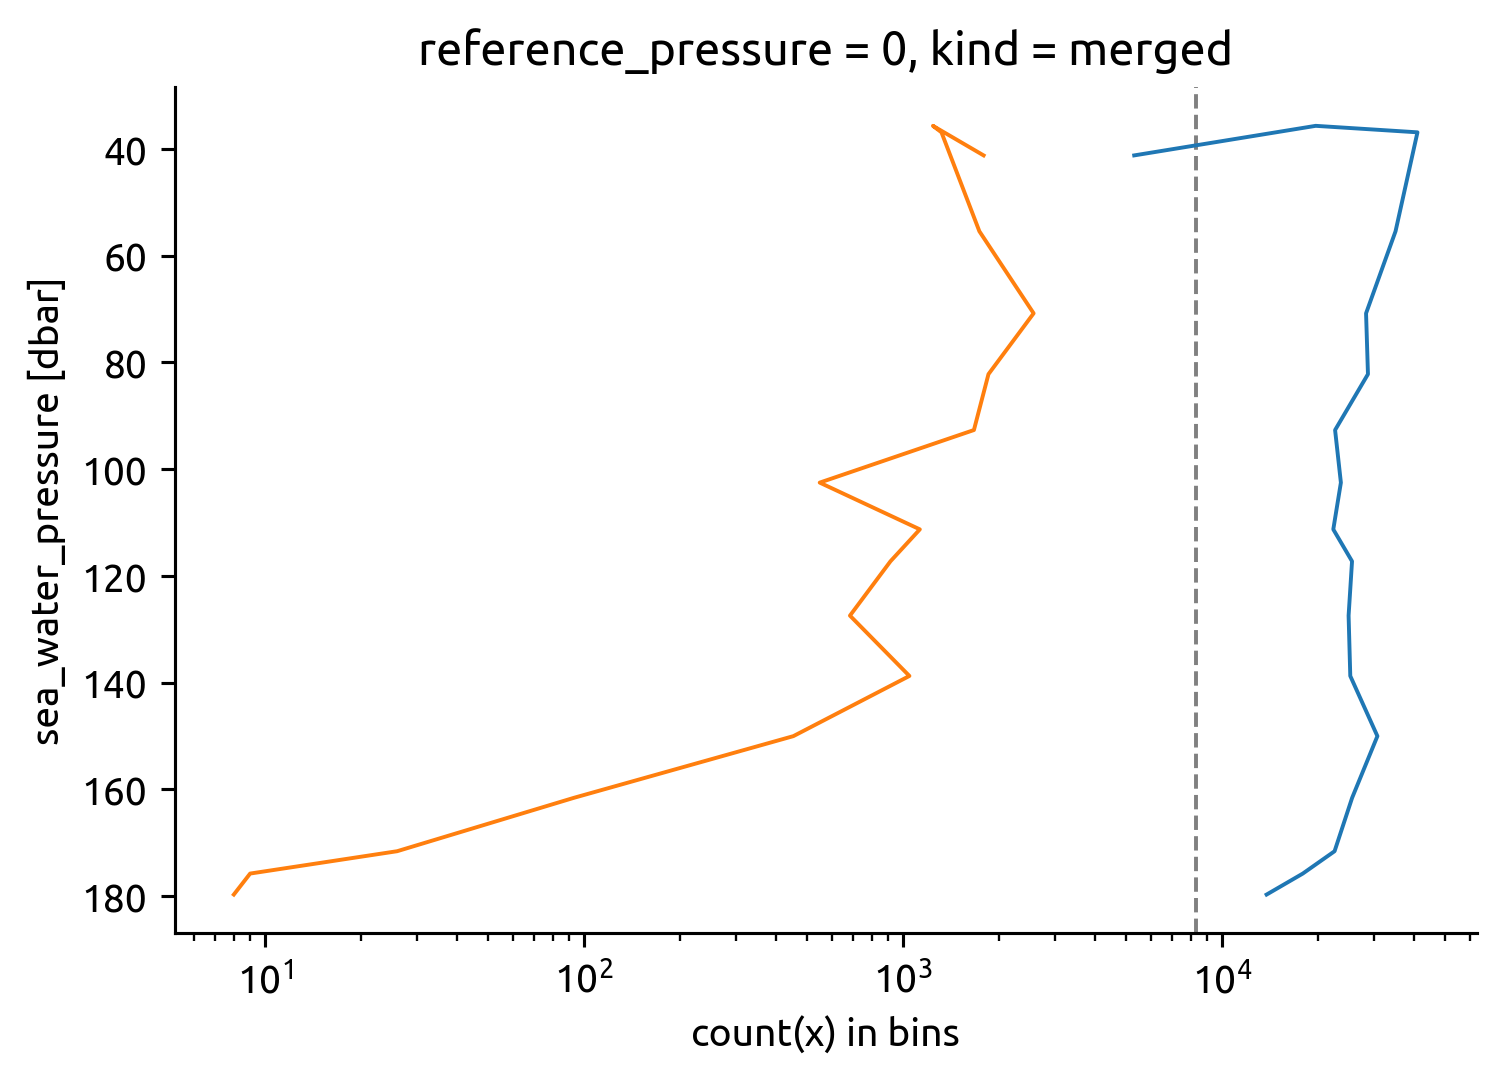

In [17]:
cham_dens.num_obs.cf.plot()
chipod_dens.num_obs.sel(kind="merged").cf.plot(y="pres", xscale="log")
dcpy.plots.linex([cham_dens.num_obs.median()/3, ])

### final result


Mostly agree. 
- It looks like  the biggest disagreement is between 100m and 120m ≈ EUCmax. 
- Note that I have used the chameleon $∂_zθ^m$
- crosses need to be moved one half-bin width down

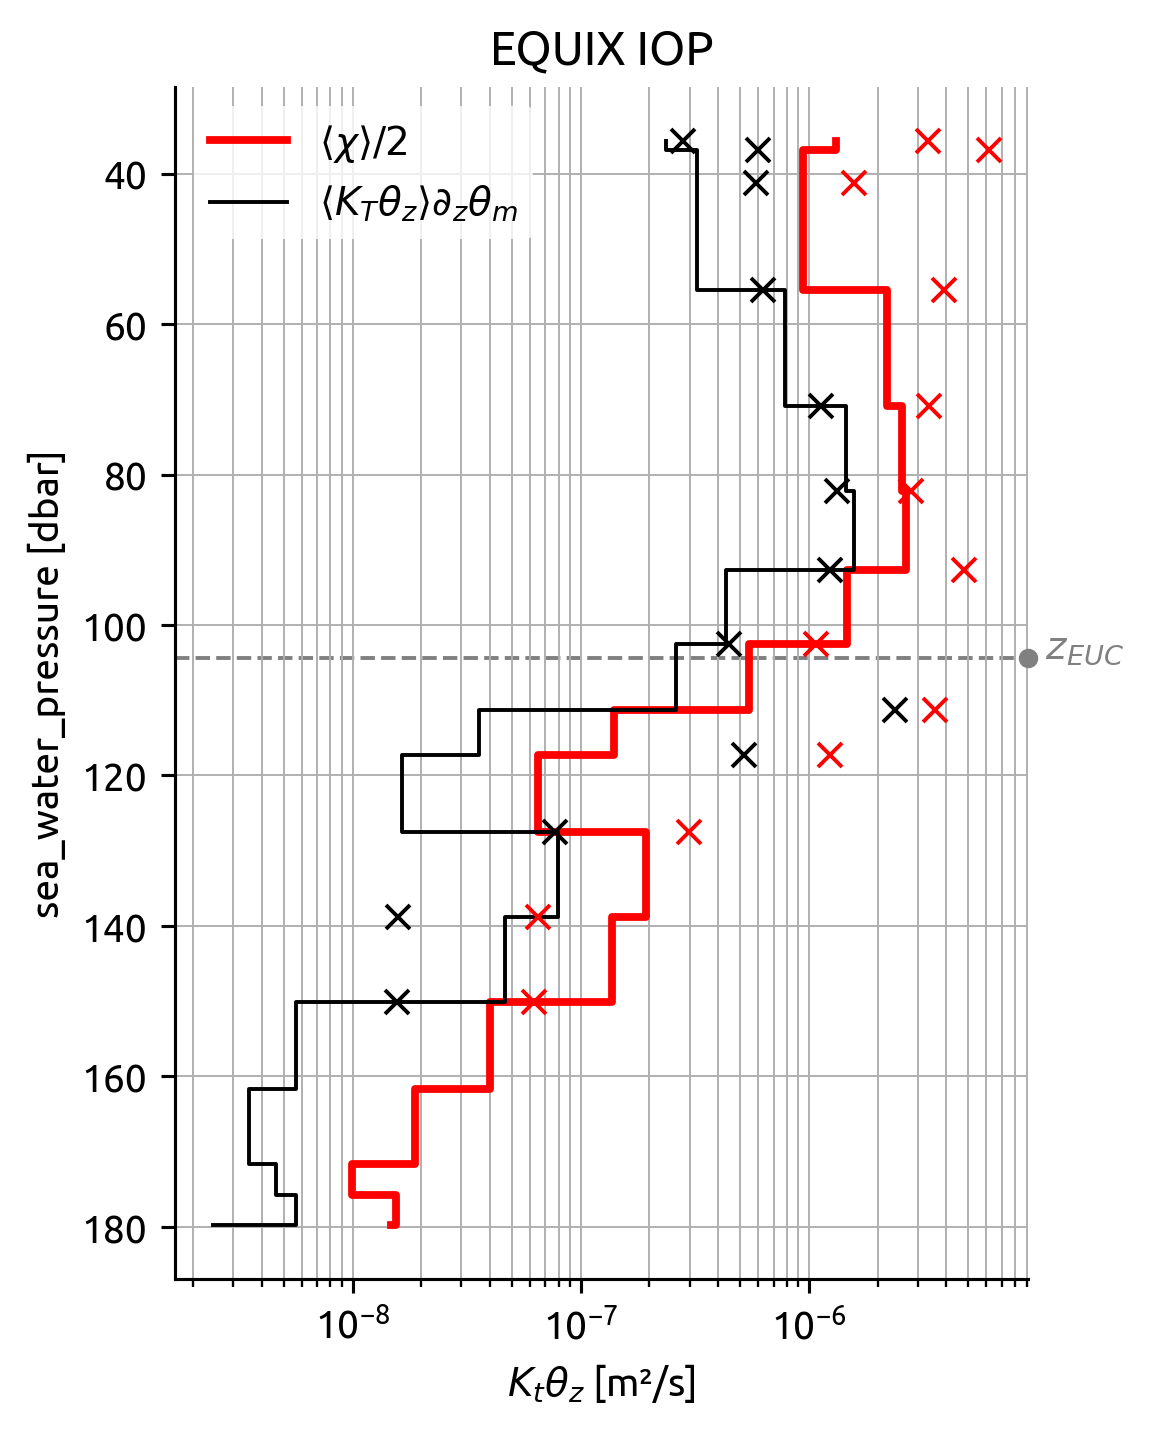

In [19]:
chipodmask = chipod_dens.num_obs > chipod_dens.num_obs.median()/3
chammask = cham_dens.num_obs > cham_dens.num_obs.median() / 3

ed.sections.plot_var_prod_diss(cham_dens.where(chammask))
chipod_dens.chi.where(chipodmask).sel(kind="merged").cf.plot(
    y="pres", marker="x", ls="none", color="r"
)
(chipod_dens.where(chipodmask).KtTz * cham_dens.dTdz_m).sel(kind="merged").cf.plot(
    y="pres", marker="x", ls="none", color="k"
)
plt.title("EQUIX IOP")
hdl = dcpy.plots.liney(chameleon.eucmax.mean().values, label="$z_{EUC}$")

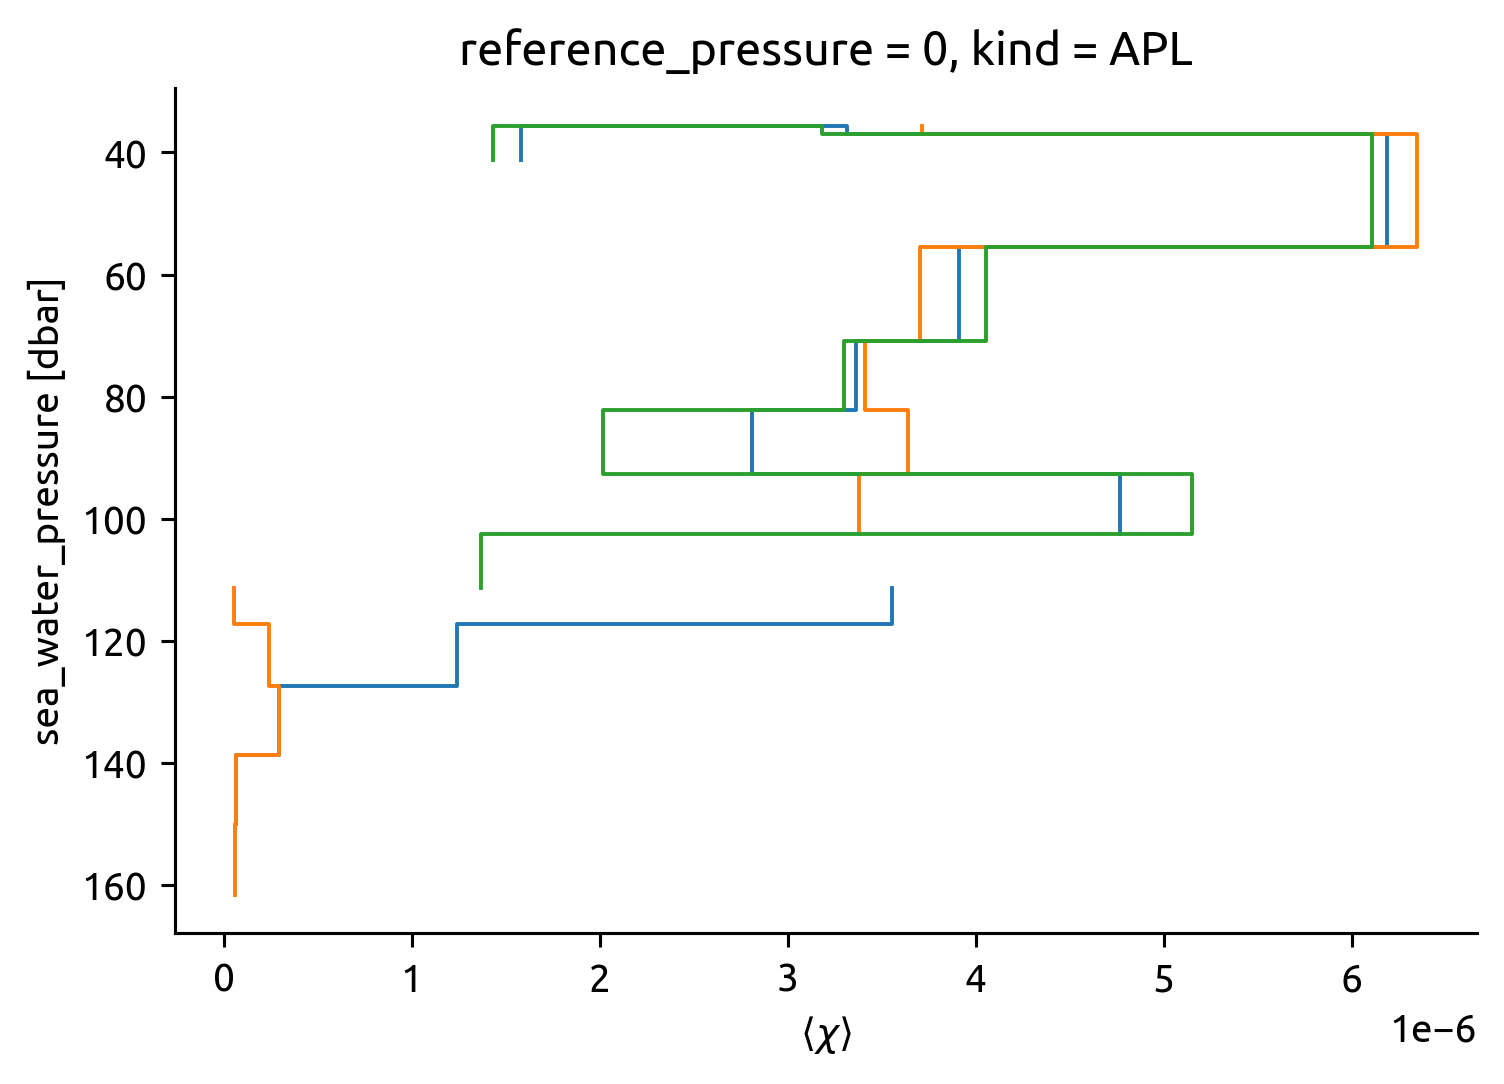

In [20]:
chipod_dens.where(chipod_dens.num_obs > 600).sel(kind="merged").chi.cf.plot.step(y="pres")
chipod_dens.where(chipod_dens.num_obs > 250).sel(kind="TAO").chi.cf.plot.step(y="pres")
chipod_dens.where(chipod_dens.num_obs > 250).sel(kind="APL").chi.cf.plot.step(y="pres")

## EQUIX EOP

- [ ] need salinity
- [ ] merge in TAO
- [ ] need to preserve time dimension while grouping

In [21]:
eop = xr.open_dataset(
    "/home/deepak/datasets/microstructure/osu/equix/hourly_eop.nc"
).rename({"dTdz": "Tz"})
eop["salt"] = 35 * xr.ones_like(eop.theta)
eop["salt"].attrs = {"standard_name": "sea_water_salinity"}
eop["T"] = dcpy.eos.temp(eop.salt, eop.theta, eop.depth)
eop.coords["pres"] = dcpy.eos.pres(eop.depth, 0)
eop.coords["latitude"] = 0
eop.coords["longitude"] = -140
eop["gamma_n"] = dcpy.oceans.neutral_density(eop)
eop["pden"] = dcpy.eos.pden(eop.salt, eop.theta, 0)
eop.attrs["name"] = "EQUIX"

/home/deepak/work/python/cf-xarray/cf_xarray/accessor.py:1289: UserWarning: Variables {'nominal_depth'} not found in object but are referred to in the CF attributes.
  warnings.warn(


### APL vs TAO

In [22]:
tao = xr.open_dataset("/home/deepak/datasets/microstructure/osu/equix/hourly_tao.nc")
tao.attrs["name"] = "TAO"

In [23]:
tao_eop = dcpy.util.slice_like(tao, eop.time).drop_sel(depth=[39, 84])
tao_eop

<xarray.Dataset>
Dimensions:  (depth: 5, time: 2692)
Coordinates:
  * time     (time) datetime64[ns] 2008-11-11T05:00:00 ... 2009-03-03T08:00:00
  * depth    (depth) int64 18 59 69 124 150
    unit     (depth) int64 ...
Data variables:
    theta    (time, depth) float64 ...
    chi      (time, depth) float64 ...
    eps      (time, depth) float64 ...
    Kt       (time, depth) float64 ...
    Jq       (time, depth) float64 ...
    dTdz     (time, depth) float64 ...
Attributes:
    name:     TAO

### n-var groupby

In [169]:
garr = np.array(tuple(tuple_groups))

In [166]:
out = np.arange(17*5, dtype=float).reshape((17, 5))
result = np.arange(55, dtype=float)
result[mask] = np.nan
out[(garr[:,0], garr[:, 1])] = result
out

array([[ 1., 12., 32., 35., 47.],
       [ 5., 13., 31., 44., 49.],
       [ 6., 15., 30., 38., 48.],
       [ 4., 19., 29., 36., 52.],
       [ 2., 20., 23., 37., 24.],
       [ 8., 14., 24., 42., 54.],
       [ 3., 16., 25., 39., 50.],
       [ 7., 17., 26., 40., 51.],
       [ 9., 18., 28., 41., 53.],
       [10., 21., 27., 43., 49.],
       [50., 22., 33., 53., 54.],
       [55., 56., 57., 58., 59.],
       [60., 61., 62., 63., 64.],
       [65., 66., 67., 68., 69.],
       [70., 71., 72., 73., 74.],
       [75., 76., 77., 78., 79.],
       [nan, nan, nan, nan, nan]])

In [25]:
v1 = eop.gamma_n
v2 = eop.time.dt.month

to_group = ((v1, bins), v2)

factorized = []
groups = []
for var in to_group:
    if isinstance(var, tuple):
        # groupby_bins
        var, bins = var
        partitioned = pd.cut(var.data.ravel(), bins)
        cat = partitioned.codes
        uniques = partitioned.categories.values
    else:
        assert isinstance(var, xr.DataArray)  # really duck array
        cat, uniques = pd.factorize(var.data.ravel())

    groups.append(uniques)
    factorized.append(var.copy(data=cat.reshape(var.shape)))

factorized = xr.broadcast(*factorized)

ngroups = len(to_group)
iters = tuple(map(lambda x: x.flat, tuple(g.data for g in factorized)))
tuples = tuple(zip(*iters))
group_idx, tuple_groups = pd.factorize(tuples)
group_idx = group_idx.reshape(factorized[0].shape)
actual_groups = [tuple(g[i] for g, i in zip(groups, idx)) for idx in tuple_groups]
group_idx

array([[ 0,  0,  1,  1,  2,  3],
       [ 0,  0,  0,  0,  4,  3],
       [ 0,  0,  1,  1,  4,  3],
       ...,
       [46, 47, 52, 47, 52, 50],
       [46, 47, 52, 47, 52, 50],
       [46, 46, 48, 46, 48, 54]])

In [26]:
from dask_groupby.core import chunk_reduce

In [27]:
result = chunk_reduce(eop.chi.data, group_idx, func=("mean",))
#result["groups"] = np.array(actual_groups)#[mask]
#result["mean"] = result["mean"]#[mask]

mask = [-1 not in tup for tup in tuple_groups.flat]
midx = pd.MultiIndex.from_tuples(actual_groups, names=["gamma_n_bins", "month"])[mask]
mean_chi = xr.DataArray(result["mean"][mask], dims="dim", coords={"dim": midx}).unstack()
mean_chi

None


<xarray.DataArray (gamma_n_bins: 11, month: 5)>
array([[1.51685515e-06, 3.96689927e-07, 4.14711936e-08, 1.67850208e-06,
        6.94813396e-07],
       [1.96385033e-06, 1.29839427e-06,            nan, 3.18327209e-06,
        3.99610050e-06],
       [1.54138636e-06,            nan, 1.00040900e-08, 2.02344455e-06,
                   nan],
       [1.24899315e-06, 1.21953300e-06, 1.27141961e-08, 3.68614593e-06,
        1.72214489e-06],
       [1.31713565e-06,            nan, 4.89376967e-08, 1.76650510e-06,
        1.96087318e-06],
       [1.49540901e-06, 7.15083359e-07, 8.97920467e-09, 3.82197060e-06,
        3.31572971e-06],
       [5.86967070e-06, 9.21742365e-07, 1.12793382e-08, 6.37249253e-07,
        2.17357436e-06],
       [2.03539875e-06, 7.66567990e-07, 5.26039628e-09, 1.83637951e-06,
        2.56623604e-06],
       [4.62578924e-07, 4.65024979e-08, 8.35800107e-09, 3.15194427e-08,
        1.50472532e-06],
       [9.97062744e-08, 9.19497097e-09,            nan, 2.62764422e-08,
        2.02520449e-06],
       [5.34411790e-09,            nan,            nan,            nan,
        1.48712626e-07]])
Coordinates:
  * gamma_n_bins  (gamma_n_bins) object (23.522, 23.593] ... (25.477, 25.732]
  * month         (month) int64 1 2 3 11 12

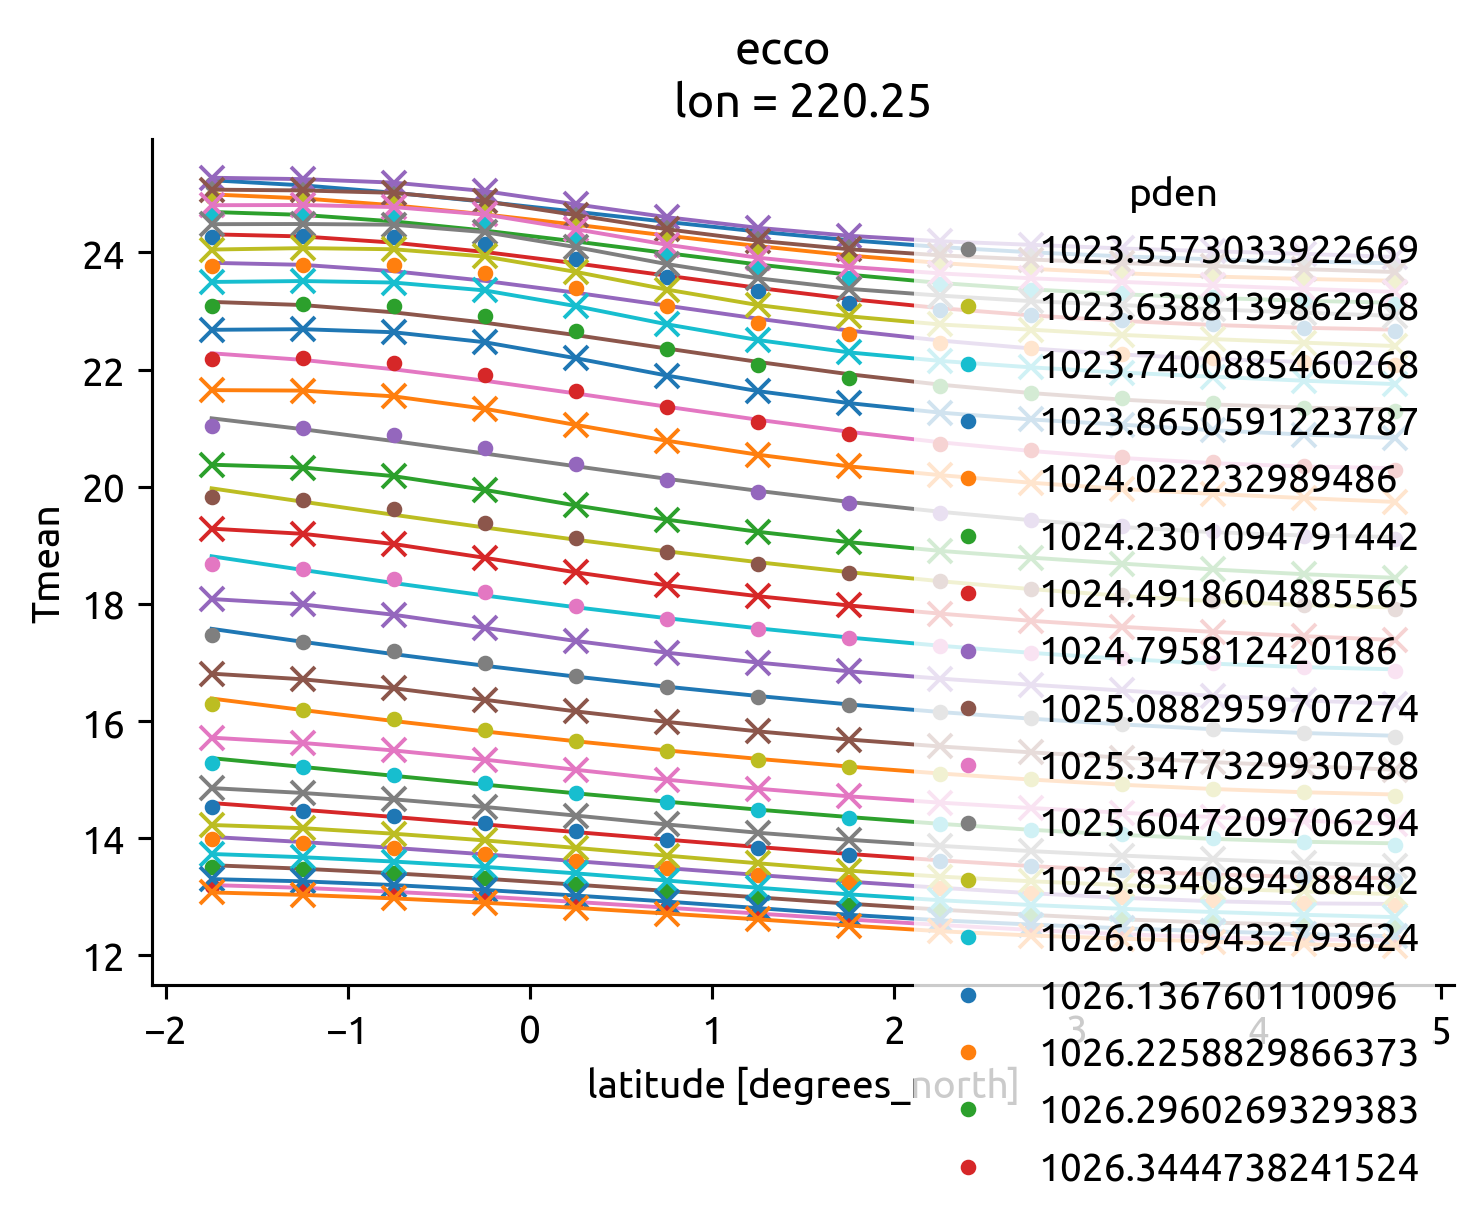

In [76]:
eccoT, edges = ed.eddydiff.estimate_gradients(
    ecco.sel(lon=220, method="nearest").sel(lat=slice(-2, 5), pres=slice(300)).mean("time"),
    bins + 1000,
    debug=True,
)
eccoT["pden"] = eccoT.pden - 1000

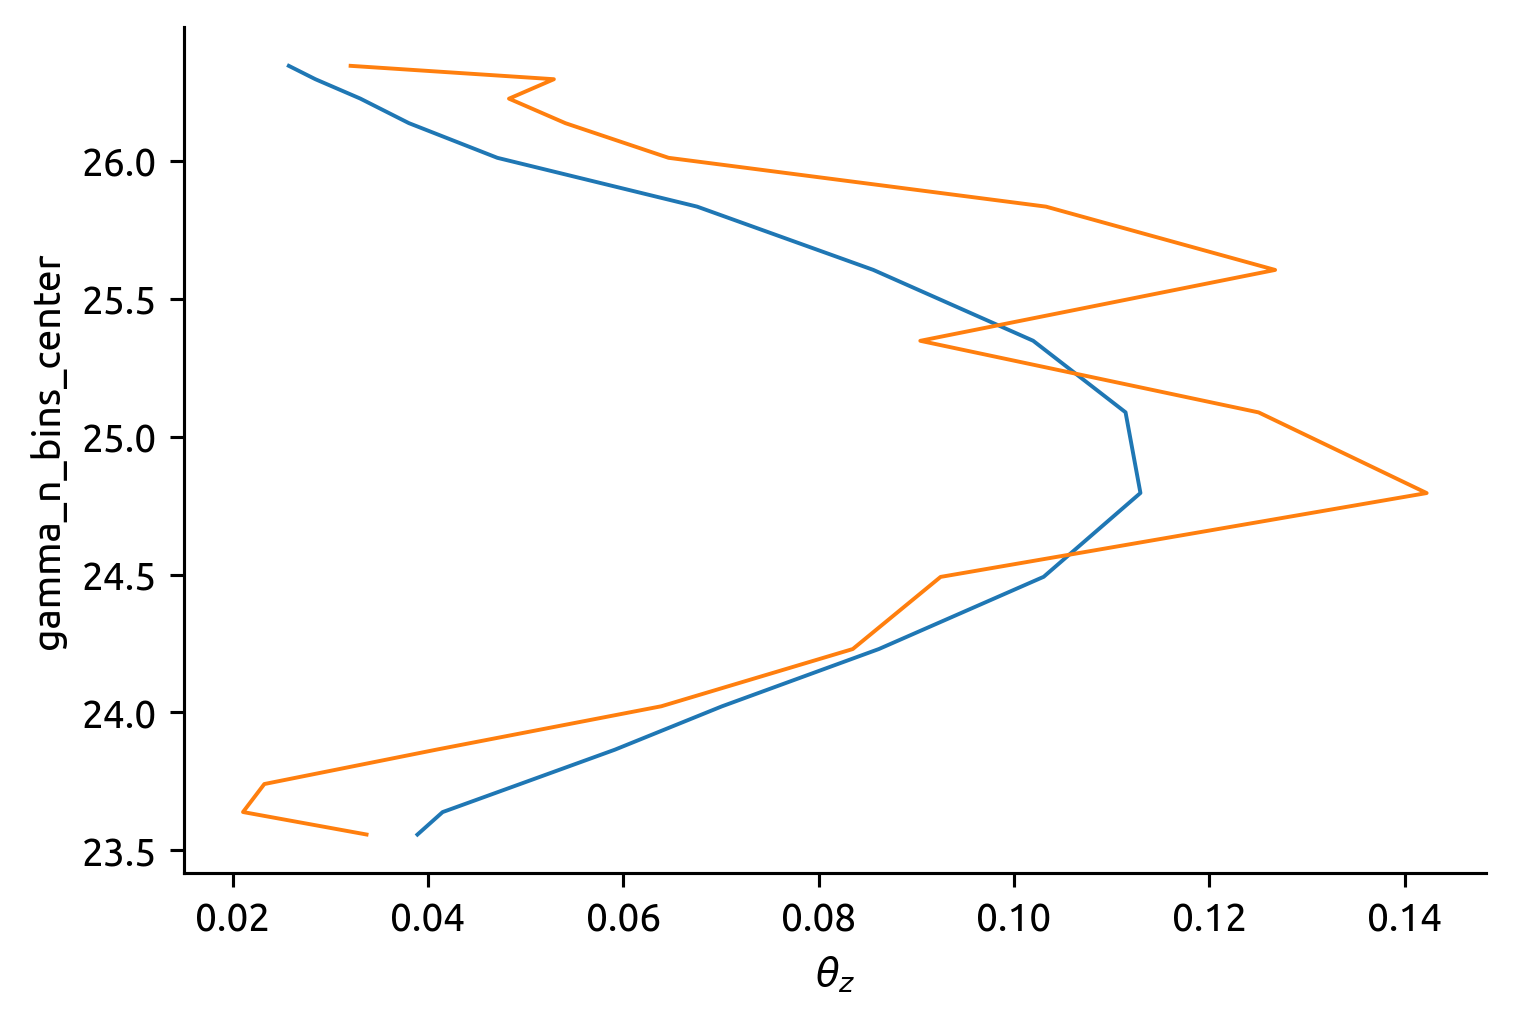

In [75]:
eccoT.interp(lat=0).dTdz.plot(y="pden")
cham_dens.Tz.plot(y="gamma_n_bins")

In [28]:
chipod_dens = ed.sections.bin_average_vertical(
    eop.where(eop.Tz > 5e-3), "neutral_density", bins
)

/home/deepak/work/python/xarray/xarray/core/nputils.py:241: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/home/deepak/work/python/xarray/xarray/core/nputils.py:241: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/home/deepak/work/python/xarray/xarray/core/nputils.py:241: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/home/deepak/work/python/xarray/xarray/core/nputils.py:241: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/home/deepak/work/python/xarray/xarray/core/nputils.py:241: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/home/deepak/work/python/xarray/xarray/core/nputils.py:241: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/home/deepak/work/python/xarray/xarray/core/nputils.py:241: RankWarning: Polyfit may be poorly condi

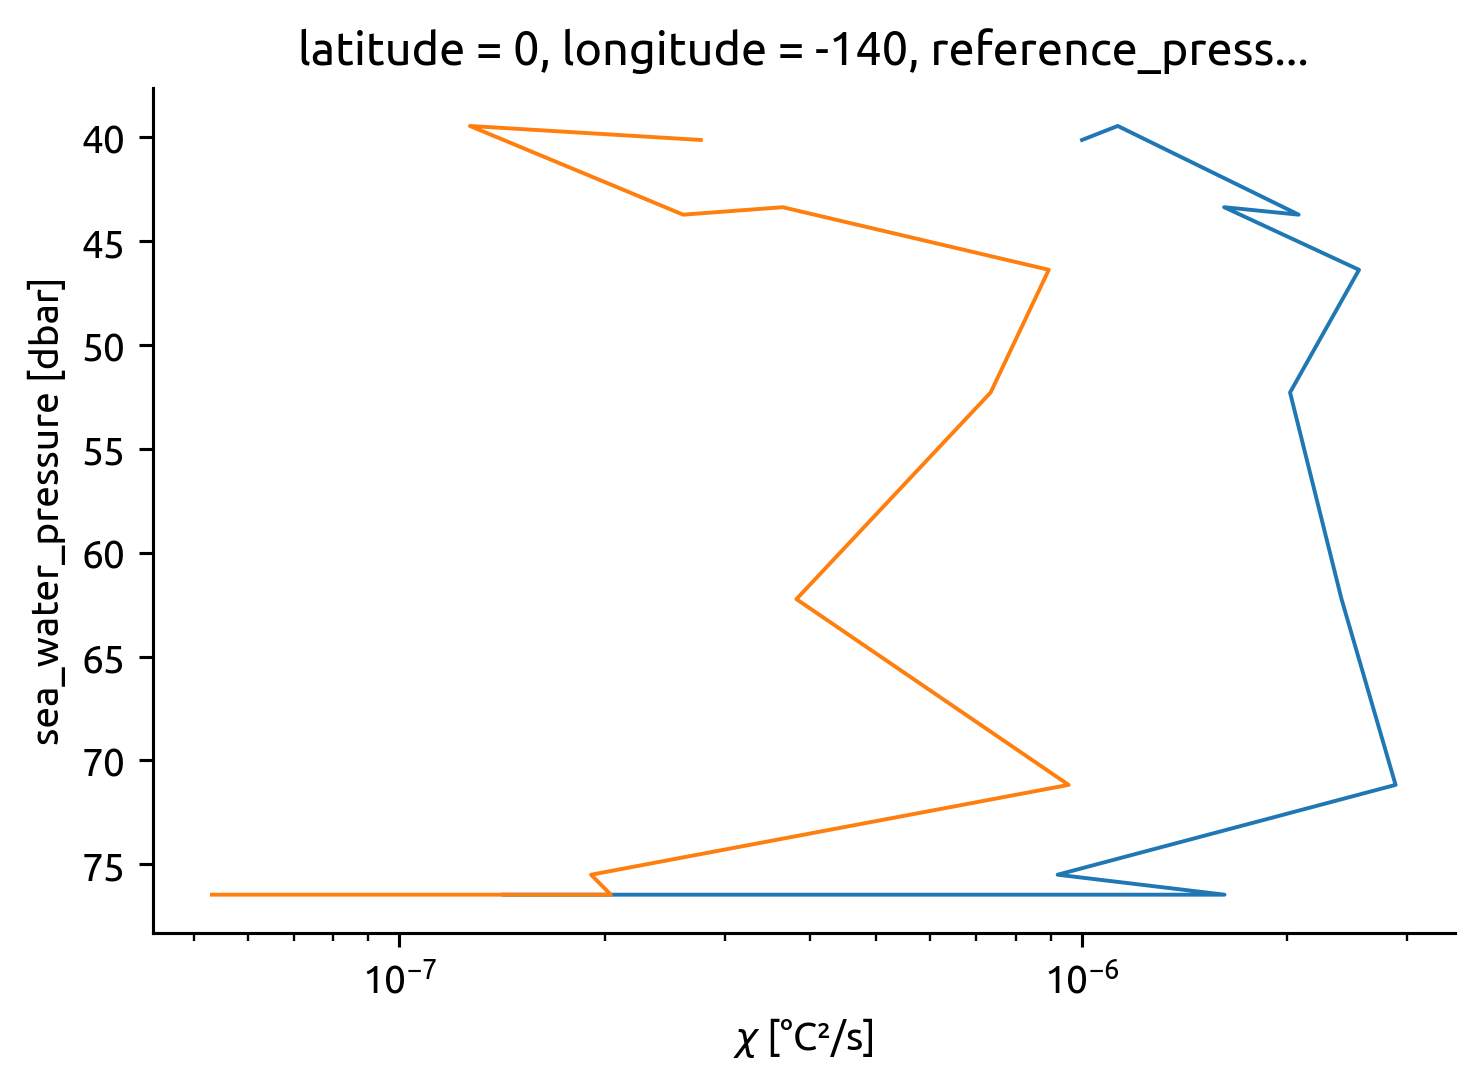

In [29]:
chipod_dens.chi.cf.plot()
(chipod_dens.KtTz * cham_dens.dTdz_m.drop_vars("pres")).cf.plot(xscale="log")